# Demo GPyTorch Workflow
## Imports

In [107]:
import torch
import gpytorch
import matplotlib.pyplot as plt

import msc

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [108]:
def load_data():
    dataset = msc.data.load_tensor_dataset()
    return dataset["train_x"], dataset["train_y"], dataset["test_x"], dataset["test_y"]

train_x, train_y, test_x, test_y = load_data()

## Plot data

<AxesSubplot:>

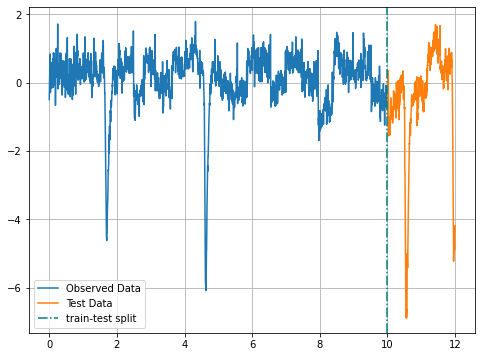

In [109]:
def plot_data(train_x, train_y, test_x, test_y):
    (f, ax) = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(train_x.numpy(), train_y.numpy(), label='Observed Data')
    ax.plot(test_x.numpy(), test_y.numpy(), label='Test Data')
    ax.axvline(10, label='train-test split', color='teal', linestyle='-.')
    ax.grid('both')
    ax.legend()
    return ax

plot_data(train_x, train_y, test_x, test_y)

# Define the GP model

In [110]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


## Initialize likelihood & model
For more info on hyperparameters, constraints and priors: [click here](https://github.com/cornellius-gp/gpytorch/blob/master/examples/00_Basic_Usage/Hyperparameters.ipynb)

In [111]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-2),
    noise_prior=gpytorch.priors.NormalPrior(0, 1))
model = ExactGPModel(train_x, train_y, likelihood)
print("The Model:\n", model)
print("The Likelihood:\n", likelihood)

The Model:
 ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): NormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-02)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)
The Likelihood:
 GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (noise_prior): NormalPrior()
    (raw_noise_constraint): GreaterThan(1.000E-02)
  )
)


## View model hyperparameters
Explicitly: objects of type torch.nn.Parameter that will have gradients filled in by autograd.

In [112]:
def print_model_params(model):
    for param_name, param in model.named_parameters():
        print(f'Parameter name: {param_name:42} value = {param.item()}')

print_model_params(model)

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.constant                       value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


## View model state dict
Both parameters and persistent buffers (e.g. running averages) are included.

In [113]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),
             ('likelihood.noise_covar.noise_prior.loc', tensor(0.)),
             ('likelihood.noise_covar.noise_prior.scale', tensor(1.)),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(0.0100)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.constant', tensor([0.])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(

## View model constraints

In [114]:
list(model.named_constraints())


[('likelihood.noise_covar.raw_noise_constraint', GreaterThan(1.000E-02)),
 ('covar_module.raw_outputscale_constraint', Positive()),
 ('covar_module.base_kernel.raw_lengthscale_constraint', Positive())]

## Train the model

In [115]:
# change from .eval() to .train() mode
# .train() mode is for optimizing model hyperparameters
# .eval() is for computing predictions through the model posterior
model.train()

mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[40])

num_iters = 1000

for i in range(num_iters):
    optimizer.zero_grad()
    output = model(train_x)  #noam: what is the output here
    loss = -mll(output, train_y) #noam: what is the output here
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(f'Iteration {i} - loss = {loss:.2f} - noise = {model.likelihood.noise.item():e}')
    scheduler.step()

C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ..\aten\src\ATen\native\Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Iteration 0 - loss = 1.11 - noise = 6.981597e-01
Iteration 10 - loss = 1.09 - noise = 6.498373e-01
Iteration 20 - loss = 1.07 - noise = 6.043692e-01
Iteration 30 - loss = 1.04 - noise = 5.616256e-01
Iteration 40 - loss = 1.01 - noise = 5.252736e-01
Iteration 50 - loss = 1.01 - noise = 5.214408e-01
Iteration 60 - loss = 1.01 - noise = 5.176620e-01
Iteration 70 - loss = 1.01 - noise = 5.139519e-01
Iteration 80 - loss = 1.00 - noise = 5.102401e-01
Iteration 90 - loss = 1.00 - noise = 5.065582e-01
Iteration 100 - loss = 1.00 - noise = 5.029089e-01
Iteration 110 - loss = 1.00 - noise = 4.992615e-01
Iteration 120 - loss = 0.99 - noise = 4.956593e-01
Iteration 130 - loss = 0.99 - noise = 4.920729e-01
Iteration 140 - loss = 0.99 - noise = 4.885071e-01
Iteration 150 - loss = 0.99 - noise = 4.849792e-01
Iteration 160 - loss = 0.98 - noise = 4.814424e-01
Iteration 170 - loss = 0.98 - noise = 4.779483e-01
Iteration 180 - loss = 0.98 - noise = 4.744721e-01
Iteration 190 - loss = 0.97 - noise = 4.70

## Make predictions
get into evaluation (predictive posterior) mode

In [117]:
model.eval()

with torch.no_grad():
    test_x_f = torch.cat([train_x, test_x], dim=-1)
    observed_pred = model.likelihood(model(test_x_f))  #noam: what is the output here
    varz = observed_pred.variance

## Plot results


In [ ]:
# with torch.no_grad():
#     # Get upper and lower confidence bounds
#     lower = observed_pred.mean - varz.sqrt() * 1.98
#     upper = observed_pred.mean + varz.sqrt() * 1.98
#
#


## Misc
* To save and load model state: [click here](https://github.com/cornellius-gp/gpytorch/blob/master/examples/00_Basic_Usage/Saving_and_Loading_Models.ipynb)



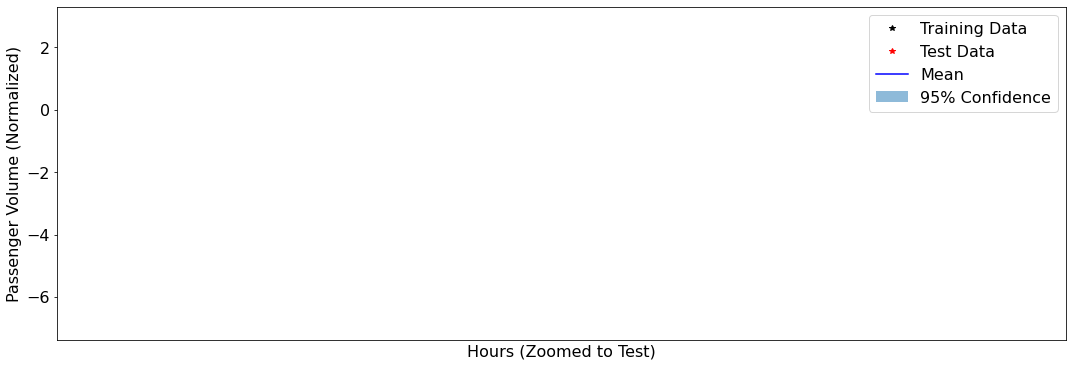

In [121]:

plt.subplots(figsize=(15, 15), sharex=True, sharey=True)
ax = plt.subplot(3, 1, 1)

with torch.no_grad():
    # Initialize plot
#         f, ax = plt.subplots(1, 1, figsize=(16, 12))

    # Get upper and lower confidence bounds
    lower = observed_pred.mean - varz.sqrt() * 1.98
    upper = observed_pred.mean + varz.sqrt() * 1.98

    # Plot training data as black stars
    ax.plot(train_x.detach().cpu().numpy(), train_y.detach().cpu().numpy(), 'k*')
    ax.plot(test_x.detach().cpu().numpy(), test_y.detach().cpu().numpy(), 'r*')
    # Plot predictive means as blue line
    ax.plot(test_x_f.detach().cpu().numpy(), (observed_pred.mean).detach().cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x_f.detach().cpu().squeeze().numpy(), lower.detach().cpu().numpy(), upper.detach().cpu().numpy(), alpha=0.5)
#     ax.set_ylim([-3, 3])
    ax.legend(['Training Data', 'Test Data', 'Mean', '95% Confidence'], fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.set_ylabel('Passenger Volume (Normalized)', fontsize=16)
    ax.set_xlabel('Hours (Zoomed to Test)', fontsize=16)
    ax.set_xticks([])

    plt.xlim([1250, 1680])

plt.tight_layout()